In [1]:
import os
from sys import stdout
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import peakutils

import matplotlib
#%matplotlib notebook
#%matplotlib inline
#matplotlib.use('nbagg')
#import mpld3
#mpld3.enable_notebook()

from math import sqrt
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict

import numpy as np
from numpy.linalg import norm
from scipy import sparse
from scipy.sparse.linalg import spsolve
from scipy.signal import savgol_filter

from baseline import baseline
from airPLS import airPLS




import warnings
warnings.filterwarnings('ignore')

In [2]:
def drPLS(x_input,y_input, **kwargs):
    """
    drPLS: (automatic) Baseline correction method based on doubly reweighted penalized least squares.
    Xu et al., Applied Optics 58(14):3913-3920.
    
    Allows subtracting a baseline under a x y spectrum.
    
    Parameters
    ----------
    x_input : ndarray
        x values.
    
    y_input : ndarray
        y values.
        
    kwargs:  #optional parameters
        niter = kwargs.get('niter',100)
        lam = kwargs.get('lam',1000000)
        eta = kwargs.get('eta',0.5)
        ratio = kwargs.get('ratio',0.001)

    Returns
    -------
    out1 : ndarray
        Contain the corrected signal.
    out2 : ndarray
        Contain the baseline.
    """
    # we get the signals in the bir
    # yafit_unscaled = get_portion_interest(x_input,y_input,bir)

    # signal standard standardization with sklearn
    # this helps for polynomial fitting
    X_scaler = StandardScaler().fit(x_input.reshape(-1, 1))
    Y_scaler = StandardScaler().fit(y_input.reshape(-1, 1))

    # transformation
    x = X_scaler.transform(x_input.reshape(-1, 1))
    y = Y_scaler.transform(y_input.reshape(-1, 1))

    #yafit = np.copy(yafit_unscaled)
    #yafit[:,0] = X_scaler.transform(yafit_unscaled[:,0].reshape(-1, 1))[:,0]
    #yafit[:,1] = Y_scaler.transform(yafit_unscaled[:,1].reshape(-1, 1))[:,0]

    y = y.reshape(len(y_input))    
    
    #according to Applied Optics, 2019, 58, 3913-3920.

    #optional parameters
    niter = kwargs.get('niter',100)
    lam = kwargs.get('lam',1000000)
    eta = kwargs.get('eta',0.5)
    ratio = kwargs.get('ratio',0.001)

    #optional smoothing in the next line, currently commented out
    #y = np.around(savgol_filter(raw_data,19,2,deriv=0,axis=1),decimals=6)

    L = len(y)

    D = sparse.diags([1,-2,1],[0,-1,-2],shape=(L,L-2),format='csr')
    D = D.dot(D.transpose())
    D_1 = sparse.diags([-1,1],[0,-1],shape=(L,L-1),format='csr')
    D_1 = D_1.dot(D_1.transpose())

    w_0 = np.ones(L)
    I_n = sparse.diags(w_0,format='csr')

    #this is the code for the fitting procedure
    w = w_0
    W = sparse.diags(w,format='csr')
    Z = w_0

    for jj in range(int(niter)):
        W.setdiag(w)
        Z_prev = Z
        Z = sparse.linalg.spsolve(W + D_1 + lam * (I_n - eta*W) * D,W*y,permc_spec='NATURAL')
        if np.linalg.norm(Z - Z_prev) > ratio:
            d = y - Z
            d_negative = d[d<0]
            sigma_negative = np.std(d_negative)
            mean_negative = np.mean(d_negative)
            w = 0.5 * (1 - np.exp(jj) * (d - (-mean_negative + 2*sigma_negative))/sigma_negative / (1 + np.abs(np.exp(jj) * (d - (-mean_negative + 2*sigma_negative))/sigma_negative)))
        else:
            break
    #end of fitting procedure

    baseline_fitted = Z

    return y_input.reshape(-1,1)-Y_scaler.inverse_transform(baseline_fitted.reshape(-1, 1)), Y_scaler.inverse_transform(baseline_fitted.reshape(-1, 1))

In [10]:
def snv(input_data):
  
    # Define a new array and populate it with the corrected data  
    data_snv = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Apply correction
        data_snv[i,:] = (input_data[i,:] - np.mean(input_data[i,:])) / np.std(input_data[i,:])
    return data_snv

In [11]:
def msc(input_data, reference=None):
    ''' Perform Multiplicative scatter correction'''
    # mean centre correction
    for i in range(input_data.shape[0]):
        input_data[i,:] -= input_data[i,:].mean()
    # Get the reference spectrum. If not given, estimate it from the mean    
    if reference is None:    
        # Calculate mean
        ref = np.mean(input_data, axis=0)
    else:
        ref = reference
    # Define a new array and populate it with the corrected data    
    data_msc = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Run regression
        fit = np.polyfit(ref, input_data[i,:], 1, full=True)
        # Apply correction
        data_msc[i,:] = (input_data[i,:] - fit[0][1]) / fit[0][0] 
    return (data_msc, ref)

In [3]:
filenames = glob('./ref_new/*')
dfs = [pd.read_csv(f) for f in filenames]
#type(dfs) #dfs is a list of dataframes 

In [4]:
df=dfs[0]

all_values=df.values
df

,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,...,1436.000000,1437.000000,1438.000000,1439.000000,1440.000000,1441.000000,1442.000000,1443.000000,1444.000000,1445.000000
0,252.0714,252.2017,252.3319,252.4622,252.5924,252.7226,252.8529,252.9831,253.1133,253.2436,...,428.7181,428.8286,428.939,429.0495,429.1599,429.2703,429.3806,429.491,429.6013,429.7116
1,4834.0000,4823.0000,4700.0000,4839.0000,4815.0000,4815.0000,4785.0000,4874.0000,4729.0000,4807.0000,...,4696.0000,4861.0000,5315.000,5161.0000,4794.0000,4690.0000,4560.0000,4533.000,4572.0000,4599.0000
2,4188.0000,4250.0000,4148.0000,4274.0000,4192.0000,4152.0000,4183.0000,4198.0000,4195.0000,4066.0000,...,3789.0000,3666.0000,3685.000,3720.0000,3722.0000,3750.0000,3675.0000,3626.000,3662.0000,3633.0000
3,4321.0000,4337.0000,4182.0000,4321.0000,4252.0000,4226.0000,4272.0000,4331.0000,4264.0000,4162.0000,...,3894.0000,3799.0000,3773.000,3761.0000,3822.0000,3831.0000,3713.0000,3758.000,3746.0000,3763.0000
4,4342.0000,4277.0000,4242.0000,4334.0000,4286.0000,4261.0000,4258.0000,4289.0000,4273.0000,4227.0000,...,3732.0000,3668.0000,3598.000,3629.0000,3706.0000,3644.0000,3672.0000,3615.000,3612.0000,3671.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,3974.0000,3921.0000,3861.0000,3989.0000,3936.0000,3897.0000,3860.0000,3944.0000,3894.0000,3824.0000,...,3468.0000,3389.0000,3418.000,3381.0000,3387.0000,3438.0000,3340.0000,3341.000,3352.0000,3347.0000
97,4159.0000,4162.0000,4157.0000,4233.0000,4191.0000,4167.0000,4193.0000,4186.0000,4166.0000,4127.0000,...,4088.0000,4176.0000,4528.000,4350.0000,4083.0000,4038.0000,3944.0000,3936.000,3903.0000,3999.0000
98,4316.0000,4344.0000,4242.0000,4372.0000,4305.0000,4304.0000,4338.0000,4345.0000,4334.0000,4272.0000,...,4751.0000,5147.0000,5928.000,5648.0000,4909.0000,4681.0000,4555.0000,4494.000,4468.0000,4624.0000
99,6095.0000,6167.0000,6035.0000,6185.0000,6105.0000,6157.0000,6121.0000,6147.0000,6092.0000,6134.0000,...,5776.0000,5773.0000,6273.000,6099.0000,5770.0000,5664.0000,5498.0000,5508.000,5393.0000,5507.0000


In [5]:
wl=all_values[0,:]
print(wl)
print(wl.shape)
print(type(wl))
print(len(wl), "\n")

data=all_values[1:,:]
print(data)
print(data.shape)
print(type(data))

[252.0714 252.2017 252.3319 ... 429.491  429.6013 429.7116]
(1446,)
<class 'numpy.ndarray'>
1446 

[[4834. 4823. 4700. ... 4533. 4572. 4599.]
 [4188. 4250. 4148. ... 3626. 3662. 3633.]
 [4321. 4337. 4182. ... 3758. 3746. 3763.]
 ...
 [4316. 4344. 4242. ... 4494. 4468. 4624.]
 [6095. 6167. 6035. ... 5508. 5393. 5507.]
 [5283. 5320. 5277. ... 5224. 5235. 5238.]]
(100, 1446)
<class 'numpy.ndarray'>


In [6]:
print(data[:,-1].shape)
print(data[-1].shape)
print(len(data))
print(len(data[0]))
print(data.shape)

(100,)
(1446,)
100
1446
(100, 1446)


<IPython.core.display.Javascript object>


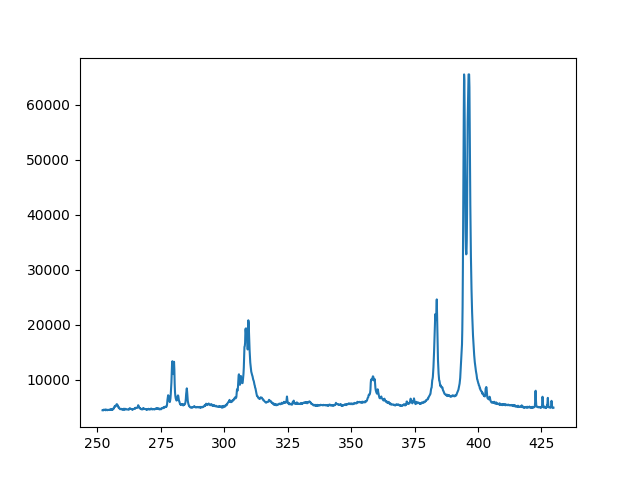

In [7]:
%matplotlib notebook
plt.plot(wl, data[20,:])
plt.show()

(1446, 1)
[5714.7292726]


<IPython.core.display.Javascript object>


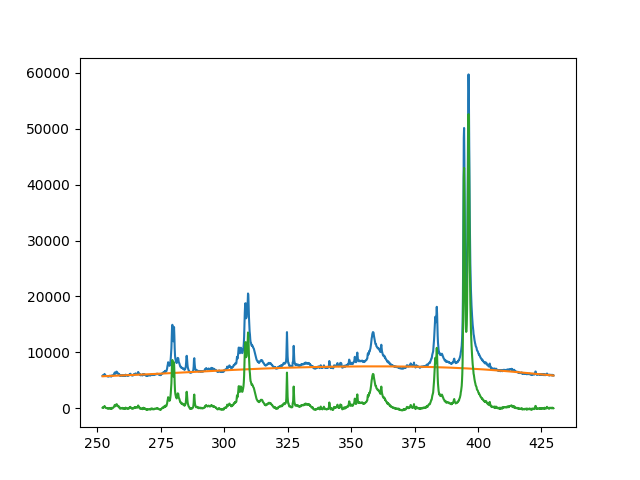

In [38]:
orig= data[10,:]

corrected, x1= drPLS(wl, orig, lam= 10e7) #lambda

print(x1.shape)
print(x1[0])

%matplotlib notebook
plt.plot(wl, orig)
plt.plot(wl, x1)
plt.plot(wl, corrected)
plt.show()

(1446, 1)
(1446,)


<IPython.core.display.Javascript object>


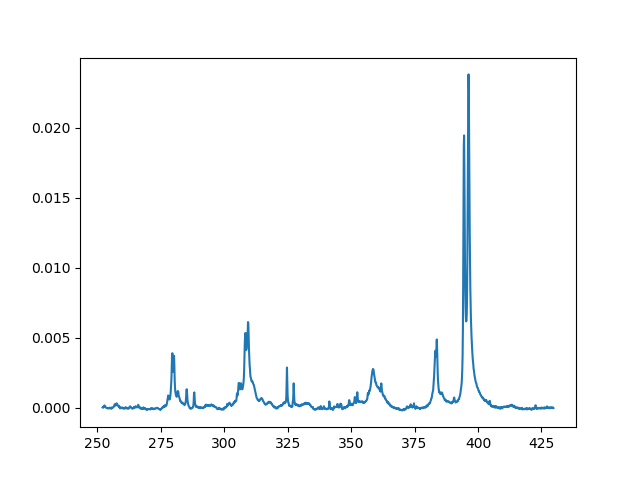

In [46]:
#a, b = msc((pd.DataFrame(corrected).dropna()).values)
a =  corrected / np.sum(corrected,axis=0)
b =  corrected / np.max(corrected,axis=0)
c= normalize (corrected.reshape(1, -1))

print(a.shape)
print(wl.shape)

%matplotlib notebook
#plt.plot(wl, corrected)
plt.plot(wl, a)
#plt.plot(wl, b)
#plt.plot(wl, c.T)
plt.show()

In [50]:
## THIS IS THE COMPLETE LOOP FOR DATA MANIPULATION

p=0.001
lam= 10000


print("the wavelength used for intensity filtering is: ", wl[445])

tot= np.empty((0, len(wl.T)))
print(tot.shape)

for j in range(0, len(dfs)): #loop over all .mat files
    data = dfs[j].values
    data = data[1:,:] #this eliminates wavelengths
    print("data index: " + str(j))
    print("data " + str(j) + " shape: ", data.shape)
    
    count=0

    #result_array = np.empty_like(wl)
    
    tmp = np.empty((0, len(wl.T)))
    
    for i in (range(len(data)) ):
        
        orig= data[i,:]
        
        #if ((max(orig)) < 65500):
        #if ((max(orig)) < 65500) and ((max(orig)) > 25500):
            
        corrected, x1= drPLS(wl, orig, lam= 10e7)

        if corrected[445] > 6000:
        #if corrected[445] > 6000 and (max(orig)) < 65500:
            count += 1

            #corrected= normalize (corrected.reshape(1, -1))
            #corrected= snv(corrected.reshape(1, -1))
            #corrected =  corrected / np.sum(corrected,axis=0)
            corrected =  corrected / np.max(corrected,axis=0)
            
            tmp = np.append(tmp, corrected.reshape(1, -1), axis=0)

            #print("a:", a.shape)
            #print("tmp:", tmp.shape)

    print("good spectra: ", count)
    print("tmp shape: ", tmp.shape)

    avg_arr= np.mean(tmp, axis=0).reshape((1, -1))
    #avg_arr= np.max(tmp, axis=0).reshape((1, -1))
    print("avg array shape: " , avg_arr.shape, "\n")
    
    
    tot = np.append(tot, avg_arr, axis=0)

print(tot.shape)  

the wavelength used for intensity filtering is:  309.506
(0, 1446)
data index: 0
data 0 shape:  (100, 1446)
good spectra:  74
tmp shape:  (74, 1446)
avg array shape:  (1, 1446) 

data index: 1
data 1 shape:  (51, 1446)
good spectra:  20
tmp shape:  (20, 1446)
avg array shape:  (1, 1446) 

data index: 2
data 2 shape:  (35, 1446)
good spectra:  30
tmp shape:  (30, 1446)
avg array shape:  (1, 1446) 

data index: 3
data 3 shape:  (46, 1446)
good spectra:  29
tmp shape:  (29, 1446)
avg array shape:  (1, 1446) 

data index: 4
data 4 shape:  (28, 1446)
good spectra:  24
tmp shape:  (24, 1446)
avg array shape:  (1, 1446) 

data index: 5
data 5 shape:  (40, 1446)
good spectra:  40
tmp shape:  (40, 1446)
avg array shape:  (1, 1446) 

data index: 6
data 6 shape:  (66, 1446)
good spectra:  8
tmp shape:  (8, 1446)
avg array shape:  (1, 1446) 

data index: 7
data 7 shape:  (32, 1446)
good spectra:  20
tmp shape:  (20, 1446)
avg array shape:  (1, 1446) 

data index: 8
data 8 shape:  (34, 1446)
good s

<IPython.core.display.Javascript object>


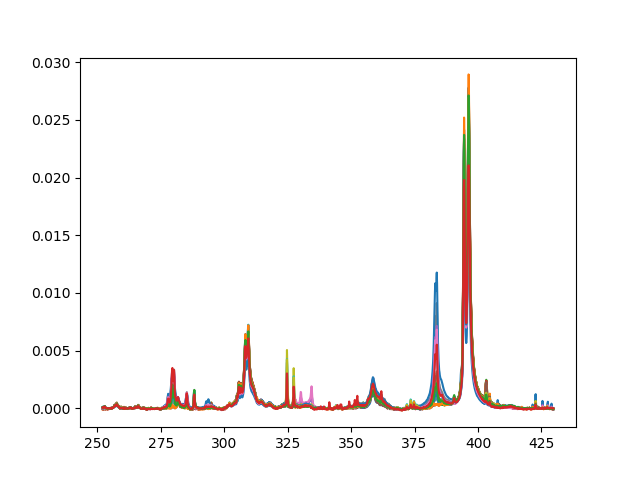

In [51]:
%matplotlib notebook
#%matplotlib inline

for i in range(len(tot)):
    #print(i)
    plt.plot(wl.T, tot[i])
    plt.show()

In [52]:
print(wl.shape)
wl1= wl.reshape(1,-1)
print(tot.shape)

a= np.append(wl1, tot, axis=0)
print(a.shape)
print(a)

np.savetxt("avg_base_wl_sum_25-02.csv", a, delimiter=",", fmt='%f')

(1446,)
(24, 1446)
(25, 1446)
[[ 2.52071400e+02  2.52201700e+02  2.52331900e+02 ...  4.29491000e+02
   4.29601300e+02  4.29711600e+02]
 [-4.48705440e-06 -1.15710453e-05 -2.93378838e-05 ... -3.52890459e-05
  -4.02128034e-05 -2.76838553e-05]
 [-9.76768508e-05 -9.63416396e-05 -1.44884278e-04 ... -1.17945953e-04
  -1.47816528e-04 -1.27085744e-04]
 ...
 [ 4.74816839e-05  3.45922371e-06 -2.66519504e-05 ... -7.35358093e-05
  -8.56540649e-05 -7.08726556e-05]
 [ 9.53310094e-05  5.10040880e-05  1.91726573e-05 ... -5.08181119e-05
  -6.48960675e-05 -5.36356546e-05]
 [ 6.60401565e-05  3.00726106e-05  2.21605571e-05 ... -1.03346126e-05
  -2.14419680e-05 -1.03461470e-05]]


In [42]:
wl[445]

309.506

### Wavelet transform

In [9]:
import pywt
import pywt.data
#print(pywt.families(short=False))
print(pywt.families(short=True), "\n")
#print(pywt.wavelist(kind='discrete'))

['haar', 'db', 'sym', 'coif', 'bior', 'rbio', 'dmey', 'gaus', 'mexh', 'morl', 'cgau', 'shan', 'fbsp', 'cmor'] 



<IPython.core.display.Javascript object>


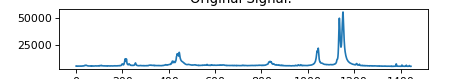

<IPython.core.display.Javascript object>


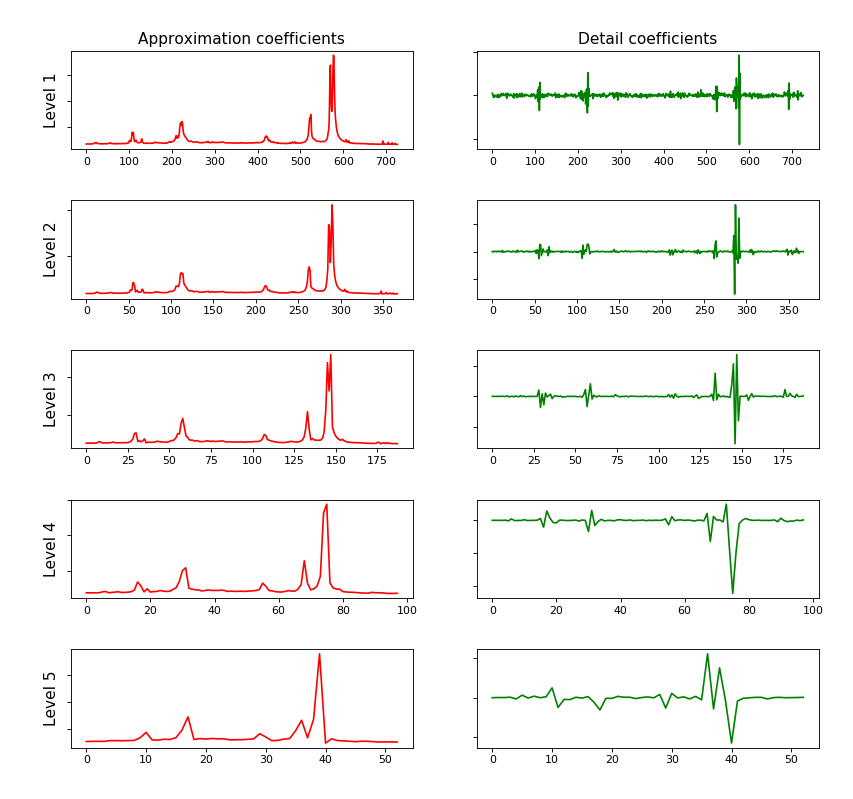

In [10]:
    
fig, ax = plt.subplots(figsize=(6,1))
ax.set_title("Original Signal: ")
ax.plot(data[0,:])
plt.show()
    
data1 = data[0,:]
waveletname = 'sym5'
 
fig, axarr = plt.subplots(nrows=5, ncols=2, figsize=(6,6))
for ii in range(5):
    (data1, coeff_d) = pywt.dwt(data1, waveletname)
    axarr[ii, 0].plot(data1, 'r')
    axarr[ii, 1].plot(coeff_d, 'g')
    axarr[ii, 0].set_ylabel("Level {}".format(ii + 1), fontsize=14, rotation=90)
    axarr[ii, 0].set_yticklabels([])
    if ii == 0:
        axarr[ii, 0].set_title("Approximation coefficients", fontsize=14)
        axarr[ii, 1].set_title("Detail coefficients", fontsize=14)
    axarr[ii, 1].set_yticklabels([])
plt.tight_layout()
plt.show()

- The DWT return two sets of coefficients; the approximation coefficients and detail coefficients.
- The approximation coefficients represent the output of the low pass filter (averaging filter) of the DWT.
- The detail coefficients represent the output of the high pass filter (difference filter) of the DWT.
- By applying the DWT again on the approximation coefficients of the previous DWT, we get the wavelet transform of the next level.
- At each next level, the original signal is also sampled down by a factor of 2.

<IPython.core.display.Javascript object>


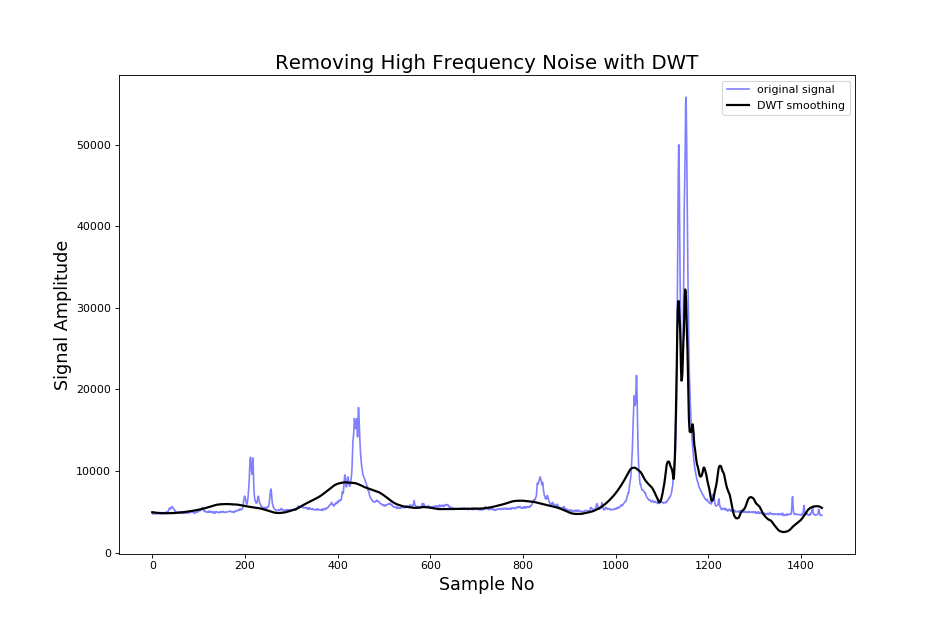

In [12]:
#Is this even useful???

signal = data[0,:]

def lowpassfilter(signal, thresh = 0.63, wavelet="coif9"):
#def lowpassfilter(signal, thresh = 0.63, wavelet="db4"):
    thresh = thresh*np.nanmax(signal)
    coeff = pywt.wavedec(signal, wavelet, mode="sp1" )
    coeff[1:] = (pywt.threshold(i, value=thresh, mode="soft" ) for i in coeff[1:])
    reconstructed_signal = pywt.waverec(coeff, wavelet, mode="sp1" )
    return reconstructed_signal
 
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(signal, color="b", alpha=0.5, label='original signal')
rec = lowpassfilter(signal, 0.4)
ax.plot(rec, 'k', label='DWT smoothing', linewidth=2)
ax.legend()
ax.set_title('Removing High Frequency Noise with DWT', fontsize=18)
ax.set_ylabel('Signal Amplitude', fontsize=16)
ax.set_xlabel('Sample No', fontsize=16)
plt.show()

# Normalization

In [16]:
data[0,:]

array([4834., 4823., 4700., ..., 4533., 4572., 4599.])

In [17]:
a= normalize(data[0,:].reshape(1, -1))
a.shape

(1, 1446)

In [18]:
print(wl.shape)
print(a.shape)

(1446,)
(1, 1446)


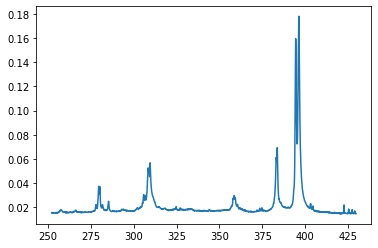

In [21]:
%matplotlib inline
plt.plot(wl, a.T)
plt.show()

(1446,)
(100, 1446)


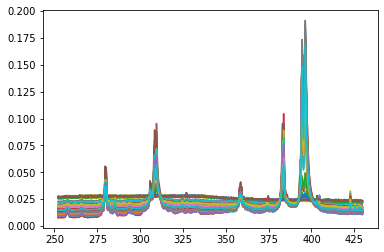

In [23]:
tmp=normalize(data)
print(wl.shape)
print(tmp.shape)


%matplotlib inline
for i in range(len(tmp)):
    plt.plot(wl, tmp[i,:])
    #plt.show()

In [24]:
print(wl.shape)
print(len(wl))

(1446,)
1446


In [ ]:
tot= np.empty((0, len(wl)))


for j in range(0, len(dfs)):
    data = dfs[j].values
    data = data[1:,:]
    print("data index: " + str(j))
    print("data " + str(j) + " shape: ", data.shape)
    
    count=0

    #result_array = np.empty_like(wl)
    
    tmp = np.empty((0, len(wl)))

    
    for i in (range(len(data)) ):
    
        z_i = baseline_als(data[i,:], lam, p, niter=10)

        a = data[i,:] - z_i


        if (max(a)) > 25000:

            #a =  a / np.sum(a,axis=0)
            #a = StandardScaler().fit_transform(a.reshape(-1, 1))
            #a= normalize(a.reshape(-1, 1))

            count += 1
            #print(i)
            #plt.plot(wl, a)
            #plt.show()
            tmp = np.append(tmp, [a], axis=0)
    
    """
    for i in (range(len(data[0])) ):
        
        z_i = baseline_als(data[:,i], lam, p, niter=10)

        a = data[:,i] - z_i    
        
    
        if ((max(a)) > 2000): # and ((max(data[:,i])) < 65500):
        #if ((max(data[:,i])) > 10000):
            count += 1
            #print(i)
            #plt.plot(wl, data[:,i])
            #plt.show()
            tmp = np.append(tmp, [a], axis=0)
    """

    print("good spectra: ", count)
    print("tmp shape: ", tmp.shape)

    avg_arr= np.mean(tmp, axis=0).reshape((1, -1))
    #avg_arr= np.max(tmp, axis=0).reshape((1, -1))
    print("avg array shape: " , avg_arr.shape)
    print("")
    
    
    tot = np.append(tot, avg_arr, axis=0)

print(tot.shape) 

In [ ]:
for i in range(len(tot)):
    plt.plot(wl, tot[i])
    #plt.show()

In [ ]:
print(tot.shape)
print(wl.shape)

In [ ]:
print(wl.shape)
wl= wl.reshape(1,-1)
print(tot.shape)

a= np.append(wl, tot, axis=0)
print(a.shape)
print(a)

In [ ]:
#np.savetxt("avg_intesities_baseline_1.csv", a, delimiter=",", fmt='%f')

In [ ]:
X_std = StandardScaler().fit_transform(data)
print(X_std.shape)
X_std

In [ ]:
data_sum= data / np.sum(data,axis=0)
data_sum

In [ ]:
for i in (range(len(X_std[0]))):
    
    plt.plot(wl, X_std[:,i] )
    plt.show()
    

In [ ]:
print(max(data[:,8]))
print(max(data[:,11]))
max(data[:,1])

In [ ]:
count = 0
for i in (range(len(data[0])) ):
    
    z_i = baseline_als(data[:,i], lam, p, niter=10)
    
    a = data[:,i] - z_i
    
    #a=  a / np.sum(a,axis=0)
    #a=  a / np.max(a,axis=0)


    count += 1
    #print(i)
    plt.plot(wl, a)
    #plt.show()
print("good spectra: ", count)

In [ ]:
count = 0
for i in (range(len(data[0])) ):
    
    z_i = baseline_als(data[600:1730,i], lam, p, niter=10)
    
    a = data[600:1730,i] - z_i
    
    
    if (max(a)) > 25000:
        
        a =  a / np.sum(a,axis=0)
        #a = StandardScaler().fit_transform(a.reshape(-1, 1))
        #a= normalize(a.reshape(-1, 1))
        
        count += 1
        #print(i)
        plt.plot(wl[600:1730], a)
        plt.show()
        #plt.savefig('./graph.png')
print("good spectra: ", count)

In [ ]:
count=0

#result_array = np.empty_like(wl)
tmp = np.empty((0, len(wl)))

for i in (range(len(data[0])) ):
    
    z_i = baseline_als(data[:,i], lam, p, niter=10)
    
    if ((max(data[:,i]-z_i)) > 10000) and ((max(data[:,i])) < 65500):
        count += 1
        #print(i)
        plt.plot(wl, data[:,i])
        #plt.show()
        tmp = np.append(tmp, [data[:,i]], axis=0)
        
        
print("good spectra: ", count)
print(tmp.shape)

avg_arr= np.max(tmp, axis=0)
#avg_arr= np.mean(tmp, axis=0)
print(avg_arr.shape)




In [ ]:
count=0

#result_array = np.empty_like(wl)
tmp = np.empty((0, len(wl)))

for i in (range(len(data[0])) ):
    if ((max(data[:,i])) > 10000) and ((max(data[:,i])) < 65500):
        count += 1
        #print(i)
        plt.plot(wl, data[:,i])
        #plt.show()
        result_array = np.append(tmp, [data[:,i]], axis=0)
        
        
print("good spectra: ", count)
print(tmp.shape)

avg_arr= np.mean(tmp, axis=0)
print(avg_arr.shape)



In [ ]:

plt.plot(wl, avg_arr)
plt.show()

In [ ]:

good = np.empty([len(wl)])

good1 = np.empty_like(wl)

print(good.shape)
print(good1.shape)

In [ ]:
print(result_array.shape)
print(result_array)
a=np.mean(result_array, axis=0)
print(a.shape)

In [ ]:
"""from glob import glob

#filenames = glob('./ref/*')
filenames = glob('./ref_1/*')


dfs = [scipy.io.loadmat(f) for f in filenames]
print(type(dfs)) #dfs is a list of mat files 
print(len(dfs)) #dfs is a list of mat files 
"""

In [ ]:
tot= np.empty((0, len(wl)))


for j in range(0, len(dfs)): #loop over all .mat files
    mat = dfs[j]
    data = mat["data"]
    print("data index: " + str(j))
    print("data " + str(j) + " shape: ", data.shape)
    
    count=0

    #result_array = np.empty_like(wl)
    
    tmp = np.empty((0, len(wl)))

    for i in (range(len(data[0])) ):
        
        
    
        if ((max(data[:,i])) > 10000) and ((max(data[:,i])) < 65500):
        #if ((max(data[:,i])) > 10000):
            count += 1
            #print(i)
            #plt.plot(wl, data[:,i])
            #plt.show()
            tmp = np.append(tmp, [data[:,i]], axis=0)


    print("good spectra: ", count)
    print("tmp shape: ", tmp.shape)

    #avg_arr= np.mean(tmp, axis=0).reshape((1, -1))
    avg_arr= np.max(tmp, axis=0).reshape((1, -1))
    print("avg array shape: " , avg_arr.shape)
    print("")
    
    
    tot = np.append(tot, avg_arr, axis=0)

print(tot.shape)  

WITH BASELINE CORRECTION

In [ ]:
tot= np.empty((0, len(wl[600:1730])))


for j in range(0, len(dfs)): #loop over all .mat files
    mat = dfs[j]
    data = mat["data"]
    print("data index: " + str(j))
    print("data " + str(j) + " shape: ", data.shape)
    
    count=0

    #result_array = np.empty_like(wl)
    
    tmp = np.empty((0, len(wl[600:1730])))

    
    for i in (range(len(data[0])) ):
    
        z_i = baseline_als(data[600:1730,i], lam, p, niter=10)

        a = data[600:1730,i] - z_i


        if (max(a)) > 25000:

            a =  a / np.sum(a,axis=0)
            #a = StandardScaler().fit_transform(a.reshape(-1, 1))
            #a= normalize(a.reshape(-1, 1))

            count += 1
            #print(i)
            plt.plot(wl[600:1730], a)
            plt.show()
            tmp = np.append(tmp, [a], axis=0)
    
    """
    for i in (range(len(data[0])) ):
        
        z_i = baseline_als(data[:,i], lam, p, niter=10)

        a = data[:,i] - z_i    
        
    
        if ((max(a)) > 2000): # and ((max(data[:,i])) < 65500):
        #if ((max(data[:,i])) > 10000):
            count += 1
            #print(i)
            #plt.plot(wl, data[:,i])
            #plt.show()
            tmp = np.append(tmp, [a], axis=0)
    """

    print("good spectra: ", count)
    print("tmp shape: ", tmp.shape)

    avg_arr= np.mean(tmp, axis=0).reshape((1, -1))
    #avg_arr= np.max(tmp, axis=0).reshape((1, -1))
    print("avg array shape: " , avg_arr.shape)
    print("")
    
    
    tot = np.append(tot, avg_arr, axis=0)

print(tot.shape)  

In [ ]:
tot= np.empty((0, len(wl[600:1730])))


for j in range(0, len(dfs)): #loop over all .mat files
    mat = dfs[j]
    data = mat["data"]
    print("data index: " + str(j))
    print("data " + str(j) + " shape: ", data.shape)
    
    count=0

    #result_array = np.empty_like(wl)
    
    tmp = np.empty((0, len(wl[600:1730])))

    
    for i in (range(len(data[0])) ):
        if (max(data[:,i])) > 25000:
            
            
            z_i = baseline_als(data[600:1730,i], lam, p, niter=10)

            a = data[600:1730,i] - z_i


        

            a =  a / np.sum(a,axis=0)
            #a = StandardScaler().fit_transform(a.reshape(-1, 1))
            #a= normalize(a.reshape(-1, 1))

            count += 1
            #print(i)
            #plt.plot(wl[600:1730], a)
            #plt.show()
            tmp = np.append(tmp, [a], axis=0)
    
    """
    for i in (range(len(data[0])) ):
        
        z_i = baseline_als(data[:,i], lam, p, niter=10)

        a = data[:,i] - z_i    
        
    
        if ((max(a)) > 2000): # and ((max(data[:,i])) < 65500):
        #if ((max(data[:,i])) > 10000):
            count += 1
            #print(i)
            #plt.plot(wl, data[:,i])
            #plt.show()
            tmp = np.append(tmp, [a], axis=0)
    """

    print("good spectra: ", count)
    print("tmp shape: ", tmp.shape)

    avg_arr= np.mean(tmp, axis=0).reshape((1, -1))
    #avg_arr= np.max(tmp, axis=0).reshape((1, -1))
    print("avg array shape: " , avg_arr.shape)
    print("")
    
    
    tot = np.append(tot, avg_arr, axis=0)

print(tot.shape)  

In [ ]:
for i in range(len(tot)):
    plt.plot(wl[600:1730], tot[i])
    #plt.show()

In [ ]:
ded #np.savetxt("avg_intesities.csv", tot, delimiter=",", fmt='%f')

In [ ]:
print(wl.shape)
wl1= wl[600:1730].reshape(1,-1)
print(tot.shape)

a= np.append(wl1, tot, axis=0)
a.shape
a

In [ ]:
#np.savetxt("avg_intesities_baseline_1.csv", a, delimiter=",", fmt='%f')